In [2]:
import pandas as pd
import gzip
import polars as pl
from pathlib import Path

pl.Config.set_tbl_rows(1000)

polars.config.Config

In [3]:
exp_name = "100M_samples_eos_zipf_min1_max20"
exp_dir = Path(f"../results/length_sampling/{exp_name}")
dfs = []

# *.json,gz
for file in exp_dir.glob("*of_100.json.gz"):
    with gzip.open(file, "rt") as f:
        df = pd.read_json(f, lines=True, orient="records")
        dfs.append(df)

print(f"{len(dfs)} files loaded")
df = pd.concat(dfs, ignore_index=True)

100 files loaded


In [10]:
import sys

sys.path.append("..")
from src.length_sampling.sampler import construct_pcfg_sampler
from src.length_sampling.grammars.pcfg import Grammar
from src.length_sampling.grammars.cfg import Nonterminal
from src.length_sampling.util import group_by, get_random_generator_and_seed
import argparse
import concurrent.futures
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import json
import gzip
from src.length_sampling.lower_bound_perplexity import (
    parts_to_perplexity,
    Parts,
)
import math

In [7]:
grammar_file = "../data_gen/base-grammar_eos_zipf.gr"
start_symbol = "S"
normalize = True
grammar = Grammar.from_file(grammar_file, Nonterminal(start_symbol), normalize)
sampler = construct_pcfg_sampler(grammar)

In [11]:
# calculate lower bound perplexity
min_length = 1
max_length = 20
valid_lengths = sampler.valid_lengths(min_length, max_length)
total_neg_log_prob = -1.0 * df["true_log_prob"].sum()

df["sent_len"] = df["sentence"].map(lambda x: len(x.split()))
total_len = (df["sent_len"] * df["count"]).sum()
num_samples = df["count"].sum()
parts = Parts(total_neg_log_prob, total_len, num_samples)
perplexity = parts_to_perplexity(parts, len(valid_lengths))
entropy = math.log(perplexity)

In [13]:
perplexity, entropy

(15.88170012977247, 2.765167511157158)

## sanity check

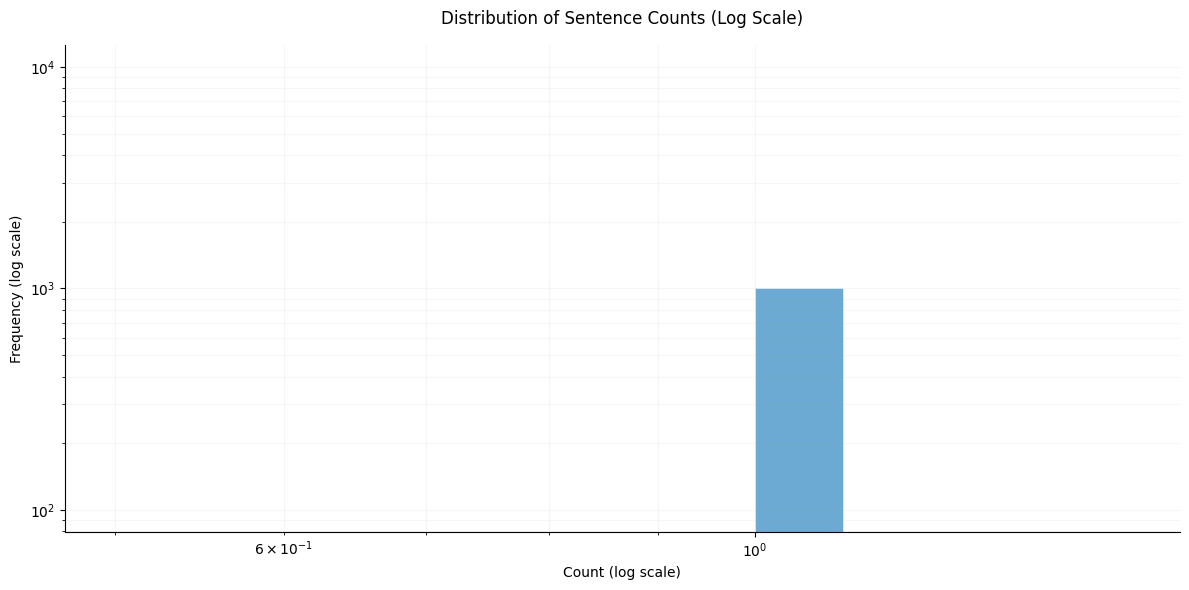

In [22]:
sample_size = 100_000_000
df["estimated_prob"] = df["count"] / sample_size


def plot_sentence_count_distribution(df, output_path):
    """
    Plots the distribution of sentence counts on a log scale.

    Args:
        df (pd.DataFrame): DataFrame containing the 'count' column.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(12, 6))

    plt.hist(
        df["count"],
        log=True,
        alpha=0.7,
        color="#2E86C1",
        edgecolor="white",
        linewidth=0.5,
    )
    plt.xscale("log")

    plt.title("Distribution of Sentence Counts (Log Scale)", fontsize=12, pad=15)
    plt.xlabel("Count (log scale)", fontsize=10)
    plt.ylabel("Frequency (log scale)", fontsize=10)
    plt.grid(True, which="both", ls="-", alpha=0.1)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

    if output_path:
        plt.savefig(output_path)


# Call the function
plot_sentence_count_distribution(df)

In [17]:
df

,sentence,count,true_log_prob,true_prob,sent_len,estimated_prob
0,prask appalates sub woggeda [eos],1,-9.486972,7.583336e-05,5,1.000000e-08
1,jurb amackists sub mangerize [eos],1,-8.753003,1.579862e-04,5,1.000000e-08
2,plonth breapers sub vem [eos],1,-13.723395,1.096492e-06,5,1.000000e-08
3,autoner sub gasted [eos],1,-9.567243,6.998409e-05,4,1.000000e-08
4,amackists sub filkeda [eos],1,-8.269017,2.563371e-04,4,1.000000e-08
...,...,...,...,...,...,...
995,streck bellion sub se sub fusilitates sa engar...,1,-36.242217,1.820561e-16,18,1.000000e-08
996,prask da prask amationists sub me sub fusbend ...,1,-45.363272,1.990587e-20,18,1.000000e-08
997,si sub ampercials ob duppify sa crail rel bena...,1,-48.046069,1.360997e-21,20,1.000000e-08
998,bo sub si sub si sub bleckman sub fusilitates ...,1,-36.157222,1.982065e-16,20,1.000000e-08


In [18]:
# KL divergence
import numpy as np
from scipy.stats import entropy

# Monte Carlo estimation
kl_div_monte_carlo = entropy(df["true_prob"], df["estimated_prob"])

print(f"KL Divergence (Monte Carlo): {kl_div_monte_carlo:.6f}")

KL Divergence (Monte Carlo): 3.896420


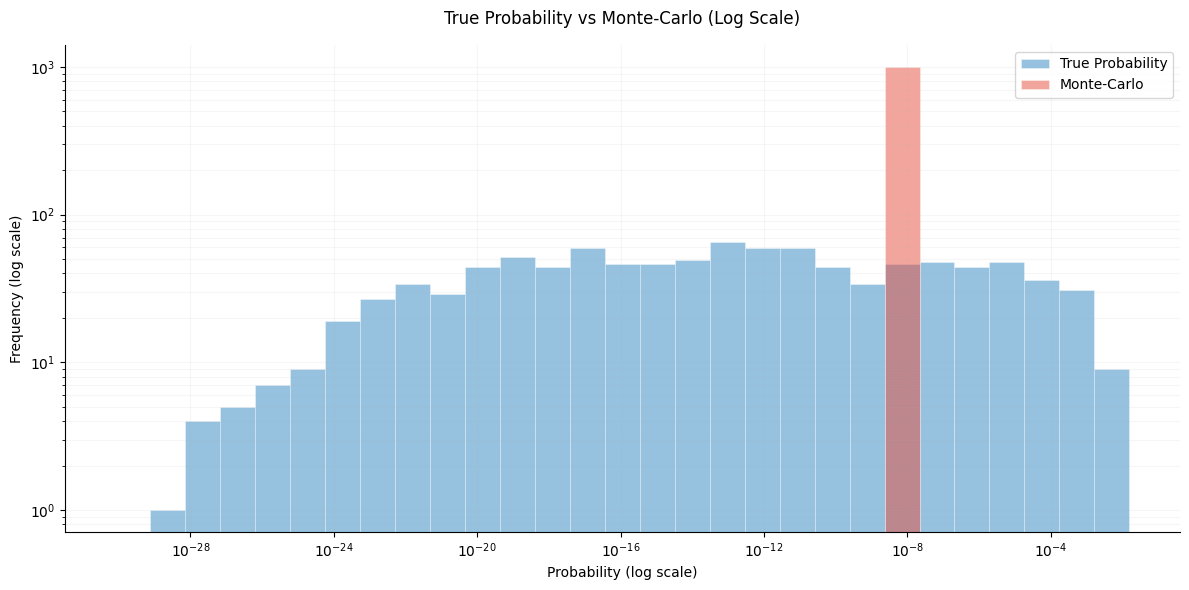

In [20]:
import matplotlib.pyplot as plt


def plot_probability_distributions(
    data, comparison_name, comparison_prob, figsize=(12, 6)
):
    """
    Plot true probability distribution with one comparison distribution

    Args:
        data (pd.DataFrame): DataFrame containing true_prob
        comparison_name (str): Name of the comparison distribution
        comparison_prob (np.array): Probability values of the comparison distribution
        figsize (tuple): Figure size
    """
    plt.figure(figsize=figsize)

    # Create bins for histogram
    bins = np.logspace(
        np.log10(data["true_prob"].min()), np.log10(data["true_prob"].max()), num=30
    )

    # Plot both distributions
    plt.hist(
        data["true_prob"],
        bins=bins,
        log=True,
        alpha=0.5,
        color="#2E86C1",
        edgecolor="white",
        linewidth=0.5,
        label="True Probability",
    )

    plt.hist(
        comparison_prob,
        bins=bins,
        log=True,
        alpha=0.5,
        color="#E74C3C",
        edgecolor="white",
        linewidth=0.5,
        label=comparison_name,
    )

    plt.xscale("log")
    plt.title(f"True Probability vs {comparison_name} (Log Scale)", fontsize=12, pad=15)
    plt.xlabel("Probability (log scale)", fontsize=10)
    plt.ylabel("Frequency (log scale)", fontsize=10)
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.1)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_probability_distributions(df, "Monte-Carlo", df["estimated_prob"])